In [1]:
%matplotlib inline
import json
import urllib2
import os
from tables import open_file
import pandas as pd
import numpy as np
import seaborn as sns 
pd.options.display.max_rows = 2000
pd.options.display.max_columns = 999

api_url = "http://api.brain-map.org/api/v2/data/query.json"
from alleninf.api import get_probes_from_genes

In [2]:
gene_names  = ['ALOX12', 'FTL']
gene_probes = {}

for gene in gene_names:
    gene_probes[gene] = get_probes_from_genes(gene)


In [3]:
gene_probes.keys()

['ALOX12', 'FTL']

In [4]:
def return_probe_expression(gene_probes_dict):
    from sklearn.decomposition import TruncatedSVD
    
    dfs   = []
    genes = gene_probes_dict.keys()
    
    print 'Fetching normalized gene expression values for:', genes
    print ''
    for gene in genes:
        probe_ids = ["'%s'" % probe_id for probe_id in gene_probes_dict[gene].keys()]
        print 'Probe IDs for Gene %s = %s' % (gene, probe_ids)
        
        api_query = api_url + "?criteria=service::human_microarray_expression[probes$in%s]" % (','.join(probe_ids))
        data = json.load(urllib2.urlopen(api_query))
        print api_query
        
        cols = ['top_struct','struct_name','struct_id', 'donor_names', 'coords_native']
        probe_cols = ['%s_'%gene + str(i) for i in gene_probes[gene].values()]
        cols = cols + probe_cols
        well_ids = [str(sample["sample"]["well"]) for sample in data["msg"]["samples"]]
        df   = pd.DataFrame(index = well_ids, columns = cols)
        
        df['top_struct']     = [sample["top_level_structure"]["name"] for sample in data["msg"]["samples"]]
        df['struct_id']      = [sample["structure"]["id"] for sample in data["msg"]["samples"]]
        df['struct_name']    = [sample["structure"]["name"] for sample in data["msg"]["samples"]]
        df['donor_names']    = [sample["donor"]["name"]for sample in data["msg"]["samples"]]
        df['coords_native']  = [sample["sample"]["mri"] for sample in data["msg"]["samples"]]

        for i, probe_id in enumerate(gene_probes[gene].values()):
            df['%s_%s'%(gene,probe_id)] = [float(expression_value) for expression_value in data["msg"]["probes"][i]["expression_level"]]
        
        dfs.append(df)
    
    # concat all probe expression dataframes
    df = pd.concat(dfs,axis =1).T.groupby(level=0).first().T
    
    # decompose probe expression values
    all_probes =  ['%s_'%gene + str(i) for gene in gene_probes_dict.keys() for i in gene_probes[gene].values()]

    df['Mean'] = df[all_probes].mean(axis=1)
    df['Median'] = df[all_probes].median(axis=1)
    
    pca = TruncatedSVD(n_components=1)
    pca.fit(np.array(np.asarray([df[probe] for probe in all_probes])))
    df['PCA'] = pca.components_[0,:]
    
    package_directory = '/Users/kanaan/SCR/Github/alleninf/alleninf'
    mni = pd.read_csv(os.path.join(package_directory, "data", "corrected_mni_coordinates.csv"), 
                        header=0, index_col=0)
    mni.index = mni.index.map(unicode) 
    df_concat = pd.concat([df,mni], axis = 1 )
    
    return df

In [5]:
df= return_probe_expression(gene_probes)

Fetching normalized gene expression values for: ['ALOX12', 'FTL']

Probe IDs for Gene ALOX12 = ["'1059252'", "'1059253'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1059252','1059253']
Probe IDs for Gene FTL = ["'1056864'", "'1056865'", "'1056866'", "'1056867'", "'1056868'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1056864','1056865','1056866','1056867','1056868']


In [6]:
df

,ALOX12_A_23_P152906,ALOX12_A_23_P152909,FTL_A_23_P50498,FTL_A_23_P50504,FTL_A_32_P155247,FTL_A_32_P158433,FTL_CUST_4420_PI416261804,coords_native,donor_names,struct_id,struct_name,top_struct,Mean,Median,PCA
154,1.6947,1.4957,11.0747,9.8758,10.2489,6.2463,13.8136,"[74, 96, 29]",H0351.2001,4055,"anterior orbital gyrus, right",frontal lobe,7.778529,9.8758,0.015760
442,1.5383,1.4731,11.0431,10.3643,10.354,6.8266,14.1971,"[137, 89, 57]",H0351.2001,4079,"frontal operculum, left",frontal lobe,7.970929,10.3540,0.016168
573,1.609,1.6074,11.8747,11.6346,11.5321,7.1766,15.263,"[125, 79, 68]",H0351.2001,4079,"frontal operculum, left",frontal lobe,8.671057,11.5321,0.017602
859,2.2493,2.1171,11.0273,9.7508,10.2415,6.4925,13.9454,"[129, 78, 81]",H0351.2001,4079,"frontal operculum, left",frontal lobe,7.974843,9.7508,0.015866
523,1.4767,1.4731,11.6411,10.931,11.0094,7.271,15.0026,"[51, 89, 68]",H0351.2001,4080,"frontal operculum, right",frontal lobe,8.400700,10.9310,0.017090
819,1.9656,1.564,10.7174,8.8729,9.2872,6.8417,13.8234,"[60, 77, 79]",H0351.2001,4080,"frontal operculum, right",frontal lobe,7.581743,8.8729,0.015232
97,1.6634,1.4731,11.0771,10.0934,10.3072,6.0438,13.7925,"[85, 96, 19]",H0351.2001,4890,"frontal pole, left, superior aspect",frontal lobe,7.778643,10.0934,0.015788
1195,1.8403,2.36,10.8892,9.1408,9.582,7.1412,14.393,"[70, 86, 19]",H0351.2001,4890,"frontal pole, left, superior aspect",frontal lobe,7.906643,9.1408,0.015760
123,1.7757,1.495,11.0182,10.2305,10.4321,6.08,13.5984,"[94, 102, 26]",H0351.2001,4048,"gyrus rectus, left",frontal lobe,7.804271,10.2305,0.015782
265,1.9332,1.6882,10.8892,9.4068,9.9101,6.5209,13.7652,"[101, 102, 33]",H0351.2001,4048,"gyrus rectus, left",frontal lobe,7.730514,9.4068,0.015532


In [7]:
up_regulated_genes = {
                    'ALOX12'     :  'arachidonate 12-lipoxygenase',
                    'ETFDH'      :  'electron-transferring-flavoprotein dehydrogenase',
                    'TFRC'       :  'transferrin receptor',
                    #'LOC59322', :  'membrane-associated guanylate kinase-interacting protein',
                    #'Tubb5'     :  'tubulin, beta 5'
                    'ACTA2'      :  'actin, alpha 2, smooth muscle, aorta',
                    'CAT'        :  'Catalase',
                    #'CDC2a'     :  'cell division cycle 2 homolog A (S. pombe)',
                    'HMGB2'      :  'High mobility group box 2',
                    'GNB1'       :  'Guanine nucleotide binding protein (G protein), beta polypeptide 1',
                    #'---'       :  'Rat mRNA for beta-tubulin T beta15'
                    'TOP2A'      :  'topoisomerase (DNA) II alpha' ,
                    'SLC11A2'    :  'Solute carrier family 11 , member 2 (proton-coupled divalent metal ion transporters)',
                    'FKBP1B'     :  'FK506 binding protein 1B, 12.6 kDa',
                    #'---'       :  'Rattus norvegicus similar to Myristoylated alanine-rich C-kinase substrate (MARCKS), mRNA',
                    #'---'       #  'Rattus norvegicus similar to protein ref (H.sapiens) KIAA0275 gene product',
                    'COL1A1'     :  'collagen, type 1, alpha 1',
                    #'LOC286978'  :  'thymosin beta-like protein', 
                    'CD48'       :  'CD48 antigen',
                    'GCH1'       :  'GTP cyclohydrolase 1',
                    'SLC16A1'    :  'Solute carrier family 16, member 1',
                    'ALAS2'      :  'aminolevulinate, delta-, synthase 2', 
                    'KDR'        :  'kinase insert domain receptor (a type III receptor tyrosine kinase)',
                    'CIRBP'      :  'cold inducible RNA binding protein',
                    'CSAD'       :  'cysteine sulfinic acid decarboxylase', 
                   }

down_regulated_genes = { 
                    'THRSP'      :  'thyroid hormone responsive protein',
                    #''          :  'Rattus norvegicus Nclone10 mRNA',
                    'TF'         :  'transferrin',
                    'MAL'        :  'mal, T-cell differentiation protein',
                    'KLK6'       :  'kallikrein-related peptidase 6', 
                    'HOMER1'     :  'homer homolog 1 (Drosophila), neuronal immediate early gene',
                    'MOBP'       :  'myelin-associated oligodendrocytic basic protein',
                    'APOD'       :  'apolipoprotein D',
                    #''          :  'Rat troponin-c mRNA'
                    'MOG'        :  'myelin oligodendrocyte glycoprotein',
                    'CRYAB'      :  'crystallin, alpha B',
                    #'Af6'       :  'afadin',
                    #''           :  'Rattus norvegicus retroviral-like ovarian specific transcript 30-1 mRNA',
                    'APOC1'      :  'apolipoprotein C-I',
                    'CA2'        :  'carbonic anhydrase II',
                    'RASGRP1'    :  'RAS guanyl releasing protein 1',
                    'STMN4'      :  'stathmin-like 4',
                    #'Rnf28'      :  'ring finger protein 28',
                    'LYZ'        :  'lysozyme', 
                    #'LOC309574' :  'olfactory receptor',
                    'GSTM1'      :  'glutathione S-transferase mu 1', 
                    'CTSS'       :  'cathepsin S', 
                    'DCK'        :  'deoxycytidine kinase',
                    #''           :  'Rattus norvegicus similar to S-100 protein, alpha chain (LOC295214), mRNA',
                    #''           :  'Rat PMSG-induced ovarian mRNA, 3’sequence, N1'
                       }

# Down-regulated genes

In [8]:
iron_upregulated_genes = up_regulated_genes.keys()
iron_downregulated_genes = down_regulated_genes.keys()
iron_downregulated_genes

['STMN4',
 'APOD',
 'RASGRP1',
 'DCK',
 'CA2',
 'CRYAB',
 'LYZ',
 'HOMER1',
 'KLK6',
 'APOC1',
 'TF',
 'MOBP',
 'CTSS',
 'MOG',
 'MAL',
 'THRSP',
 'GSTM1']

In [9]:
gene_names  = iron_downregulated_genes
gene_probes = {}

for gene in gene_names:
    gene_probes[gene] = get_probes_from_genes(gene)

df_iron_down_regulated = return_probe_expression(gene_probes)

Fetching normalized gene expression values for: ['STMN4', 'APOD', 'RASGRP1', 'DCK', 'CA2', 'CRYAB', 'LYZ', 'TF', 'KLK6', 'APOC1', 'HOMER1', 'MOBP', 'CTSS', 'MOG', 'MAL', 'THRSP', 'GSTM1']

Probe IDs for Gene STMN4 = ["'1038344'", "'1038345'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1038344','1038345']
Probe IDs for Gene APOD = ["'1059134'", "'1059135'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1059134','1059135']
Probe IDs for Gene RASGRP1 = ["'1020208'", "'1010857'", "'1015234'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1020208','1010857','1015234']
Probe IDs for Gene DCK = ["'1057706'", "'1057707'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1057706','1057707']
Probe IDs for Gene CA2 = ["'1058656'", "'1058657'"]
http://api.brain-map.org/

In [10]:
df_iron_down_regulated

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


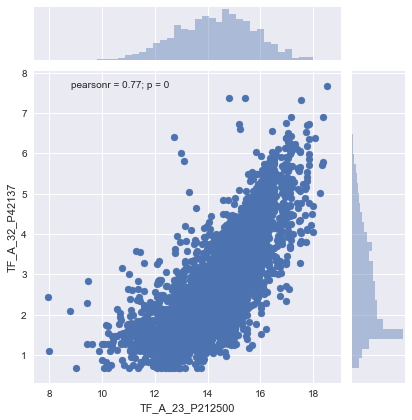

In [11]:
sns.jointplot(x ='TF_A_23_P212500', y = 'TF_A_32_P42137', data=df_iron_down_regulated )

In [12]:
from alleninf.api import get_mni_coordinates_from_wells
print "Translating locations of the wells to MNI space"
mni_coordinates = get_mni_coordinates_from_wells([int(i) for i in df_iron_down_regulated.index])

Translating locations of the wells to MNI space


In [13]:
from alleninf.data import get_values_at_locations
nifti_values = get_values_at_locations(nifti_file = '/Users/kanaan/SCR/workspace/tmp/randomise_vox_corrp_tstat1.nii.gz', 
                                       locations= mni_coordinates, 
                                       radius=2, 
                                       verbose=True, 
                                       #mask_file = '/usr/local/fsl/data/atlases/Striatum/striatum-structural-1mm.nii.gz'
                                       mask_file = '/Users/kanaan/SCR/workspace/tmp/mask2.nii.gz'
                                      )


Pearson correlation between nifti and Median across all donors is nan (two tailed p value = 1)


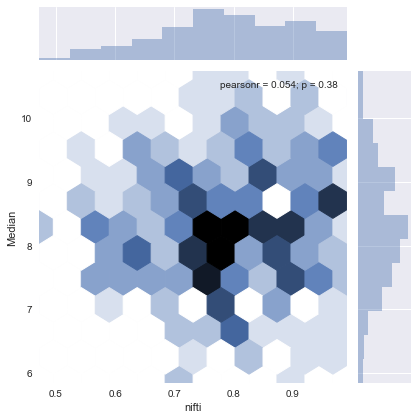

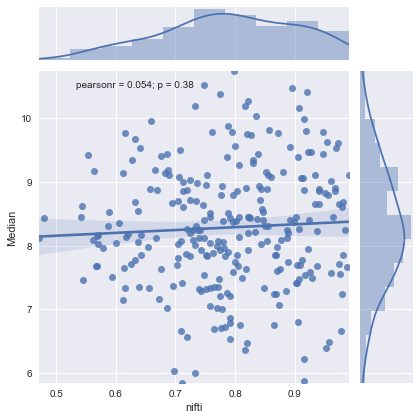

(nan, 1.0)

In [19]:
from alleninf.analysis import fixed_effects

df_iron_down_regulated['nifti'] = nifti_values
fixed_effects(df_iron_down_regulated, ["nifti", "Median"])

# Up-regulated genes

In [15]:
iron_upregulated_genes

['ACTA2',
 'SLC11A2',
 'CD48',
 'SLC16A1',
 'HMGB2',
 'GCH1',
 'GNB1',
 'CSAD',
 'ETFDH',
 'CAT',
 'ALAS2',
 'TFRC',
 'FKBP1B',
 'ALOX12',
 'COL1A1',
 'CIRBP',
 'KDR',
 'TOP2A']

In [16]:
gene_names  = iron_upregulated_genes
gene_probes = {}

for gene in gene_names:
    gene_probes[gene] = get_probes_from_genes(gene)

df_iron_up_regulated = return_probe_expression(gene_probes)

Fetching normalized gene expression values for: ['ACTA2', 'SLC11A2', 'CD48', 'SLC16A1', 'HMGB2', 'GCH1', 'GNB1', 'CSAD', 'ETFDH', 'CAT', 'ALAS2', 'TFRC', 'FKBP1B', 'ALOX12', 'COL1A1', 'CIRBP', 'KDR', 'TOP2A']

Probe IDs for Gene ACTA2 = ["'1059442'", "'1059443'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1059442','1059443']
Probe IDs for Gene SLC11A2 = ["'1053568'", "'1053567'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1053568','1053567']
Probe IDs for Gene CD48 = ["'1058433'", "'1058434'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1058433','1058434']
Probe IDs for Gene SLC16A1 = ["'1051405'", "'1051406'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1051405','1051406']
Probe IDs for Gene HMGB2 = ["'1017776'"]
http://api.brain-map.org/api/v2/da

In [18]:
from alleninf.analysis import fixed_effects
df_iron_all['nifti'] = nifti_values

fixed_effects(df_iron_up_regulated, ["nifti", "Median"])

KeyError: 'nifti'

# All genes

In [ ]:
gene_names  = iron_upregulated_genes + iron_downregulated_genes
gene_probes = {}

for gene in gene_names:
    gene_probes[gene] = get_probes_from_genes(gene)

df_iron_all = return_probe_expression(gene_probes)

In [ ]:
df_iron_all['nifti'] = nifti_values
fixed_effects(df_iron_all, ["nifti", "Median"])

In [ ]:
df_iron_all['nifti'] = nifti_values

iron_upregulated_genes = up_regulated_genes.keys()
iron_downregulated_genes = down_regulated_genes.keys()


fixed_effects(df_iron_all, ["nifti", "Median"])

In [ ]:
all_probes =  ['%s_'%gene + str(i) for gene in gene_probes.keys() for i in gene_probes[gene].values()]

for probe in all_probes:
    fixed_effects(df_iron_all, ["nifti", probe])